In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import rasterstats
import xarray as xr

import rioxarray
import stackstac
import pystac_client
import rasterio
from pystac import ItemCollection
import matplotlib.pyplot as plt
import bottleneck as bn
from multiprocessing import Pool
import time
import pyproj
import dask
import re
import itertools

In [ ]:
import time, psutil, os, resource

start_time = time.time()
process = psutil.Process(os.getpid())
start_mem = process.memory_info().rss / (1024 ** 2) 

In [3]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 70.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46411,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 70.00 GiB
Comm: tcp://127.0.0.1:38053,Total threads: 1
Dashboard: http://127.0.0.1:43113/status,Memory: 35.00 GiB
Nanny: tcp://127.0.0.1:40387,


2025-07-29 10:41:56,661 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle b7aa589d3b1a4509ca3b1ad2e4f4aefd initialized by task ('rechunk-transfer-865bec26657c291c1a9f0ca817f5d517', 0, 7, 1, 0, 0, 7, 5, 1) executed on worker tcp://127.0.0.1:39273
2025-07-29 10:42:01,161 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle b7aa589d3b1a4509ca3b1ad2e4f4aefd deactivated due to stimulus 'task-finished-1753774921.1602786'
2025-07-29 10:42:53,070 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 74687e15a2f0ff3653b77c7a7ab132af initialized by task ('rechunk-transfer-865bec26657c291c1a9f0ca817f5d517', 0, 7, 0, 1, 0, 7, 1, 2) executed on worker tcp://127.0.0.1:38053
2025-07-29 10:43:09,354 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle cad81251e0c0cbf1b8f19ee3a1e14c4b initialized by task ('rechunk-transfer-865bec26657c291c1a9f0ca817f5d517', 0, 6, 0, 1, 0, 6, 2, 2) executed on worker tcp://127.0.0.1:39273
2025-07-29 10:43:24,794 - distributed.shuffle._sched

In [5]:
path_to_aoi = r"stands_AOI.gpkg"
aoi_data = gpd.read_file(path_to_aoi)
aoi_data_wgs = aoi_data.to_crs(crs="EPSG:4326")

bbox = list(aoi_data.bounds.loc[0])
bbox_wgs = list(aoi_data_wgs.bounds.loc[0])

In [6]:
print(bbox)
print(bbox_wgs)

[596000.0000000009, 6912000.000000004, 614000.0000000009, 6936000.0]
[28.85293582102271, 62.32208325626651, 29.215953867109075, 62.542453897106675]


In [7]:
URL = "https://paituli.csc.fi/geoserver/ogc/stac/v1"
catalog = pystac_client.Client.open(URL)
catalog

<Client id=GeoserverSTACLandingPage>

In [8]:
def get_data(*, item_collection, assets, bbox, epsg, resolution, time_period):
    num_found_items = len(item_collection.items)
    print(f'Found items: {num_found_items}')
    
    gdf = None
    if num_found_items > 0:
        # ItemCollection as GeoJson 
        #stac_json = search.item_collection_as_dict()
        stac_json = item_collection.to_dict()
        
        # Add Item ID to properties to have access to it in GeoPandas
        for a in stac_json['features']:
            a['properties']['title']=a['id']
        
        # GeoJson as GeoPandas dataframe
        gdf = gpd.GeoDataFrame.from_features(stac_json, f"epsg:{epsg}")

    stack = stackstac.stack(
        items=item_collection,
        assets=assets,
        bounds=bbox,
        epsg=epsg,
        resolution=resolution
    ).squeeze()

    #resampled = stack.resample(time=time_period).median("time", skipna=True, keep_attrs=True)

    return gdf, stack

In [9]:
search_pre_2020 = catalog.search(
    bbox=bbox_wgs,
    collections=["sentinel_2_11_days_mosaics_at_fmi"],
    datetime="2019-04-01/2019-10-31"
)

search_post_2020 = catalog.search(
    collections=["sentinel_2_11_days_mosaics_at_fmi"],
    datetime="2020-04-01/2023-10-31",
    bbox=bbox_wgs
)
#2020-04-01/2023-10-31
item_collection_1 = search_pre_2020.item_collection()
item_collection_2 = search_post_2020.item_collection()
all_items = item_collection_1.items + item_collection_2.items
print(f'Found items: {len(all_items)}')
all_collection = ItemCollection(all_items)

s2_11_d_gdf, s2_11_d_data_all = get_data(
    item_collection=all_collection,
    assets=['b02', 'b03', 'b04', 'b05', 'b06', 'b07', 'b08', 'b8a', 'b11', 'b12','quality_scene_classification'],
    bbox=bbox,
    epsg=3067,
    resolution=10,
    time_period="MS"
)

# get summer months only
s2_11_d_data = s2_11_d_data_all.sel(time=s2_11_d_data_all.time.dt.month.isin([4, 5, 6, 7, 8, 9, 10]))

Found items: 135
Found items: 135


In [11]:
#values scaled to [0,1]
s2_11_d_data_reduced = s2_11_d_data.sel(
    band=s2_11_d_data.band.where(~s2_11_d_data.band.isin(["quality_scene_classification"]), drop=True)
)
s2_11_d_data_reduced = (s2_11_d_data_reduced / 10000).astype("float32")

#cloud-masking. saturated or defective pixels, cloud shadows, clouds on medium and high probability, and thin cirrus (classes 0, 1, 3, 8, 9, and 10) were filtered out
qsc = s2_11_d_data.sel(band="quality_scene_classification")
valid_mask = qsc.isin([2, 4, 5, 6, 7])
#n_valid_pixels = valid_mask.sum().compute().item()
s2_11_d_data_masked = s2_11_d_data_reduced.where(valid_mask)
s2_11_d_data_masked = s2_11_d_data_masked.assign_coords(band=s2_11_d_data_reduced.band) #loses metadata otherwise
s2_11_d_data_masked.attrs = s2_11_d_data.attrs
#s2_11_d_data = s2_11_d_data_masked
#s2_11_d_data

In [12]:
#(time, y, x)
pixels_with_zero = (s2_11_d_data == 0).any(dim='band')
indices = np.argwhere(pixels_with_zero.values)
indices

array([[   0,    0,    0],
       [   0,    0,    1],
       [   0,    0,    2],
       ...,
       [  73, 2397,  160],
       [  73, 2397,  161],
       [  73, 2397,  162]])

In [ ]:
step = 10
total_pixels = 0

for start in range(0, s2_11_d_data.sizes['time'], step):
    chunk = s2_11_d_data_reduced.isel(time=slice(start, start + step)).compute()
    total_pixels += chunk.count().sum().item()
print(total_pixels)

"\nstep = 10\ntotal_pixels = 0\n\nfor start in range(0, s2_11_d_data.sizes['time'], step):\n    chunk = s2_11_d_data_reduced.isel(time=slice(start, start + step)).compute()\n    total_pixels += chunk.count().sum().item()\nprint(total_pixels)\n"

In [ ]:
step = 10
total_pixels_masked = 0
for start in range(0, s2_11_d_data_masked.sizes['time'], step):
    chunk = s2_11_d_data_masked.isel(time=slice(start, start + step)).compute()
    total_pixels_masked += chunk.count().sum().item()
print(total_pixels_masked)

"\nstep = 10\ntotal_pixels_masked = 0\nfor start in range(0, s2_11_d_data_masked.sizes['time'], step):\n    chunk = s2_11_d_data_masked.isel(time=slice(start, start + step)).compute()\n    total_pixels_masked += chunk.count().sum().item()\nprint(total_pixels_masked)\n"

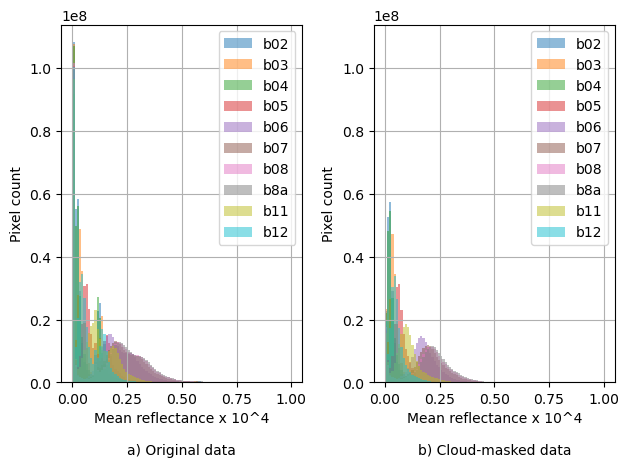

In [15]:
bins = np.linspace(0, 1, 100)
bands = s2_11_d_data_reduced.band.values
fig, axs = plt.subplots(1, 2, tight_layout=True)
for band in bands:
    values_pre = s2_11_d_data_reduced.sel(band=band).values.flatten()
    axs[0].hist(values_pre, bins, alpha= 0.5, label=str(band), histtype='stepfilled')
    values_after = s2_11_d_data_masked.sel(band=band).values.flatten()
    axs[1].hist(values_after, bins, alpha= 0.5, label=str(band), histtype='stepfilled')
axs[0].text(0.5, -0.2, "a) Original data", ha='center', transform=axs[0].transAxes)
axs[1].text(0.5, -0.2, "b) Cloud-masked data", ha='center', transform=axs[1].transAxes)
axs[0].set_xlabel('Mean reflectance x 10^4')
axs[1].set_xlabel('Mean reflectance x 10^4')
axs[0].set_ylabel('Pixel count')
axs[1].set_ylabel('Pixel count')
axs[0].legend()
axs[1].legend()
axs[0].grid(True)
axs[1].grid(True)
axs[0].set_ylim(0, axs[0].get_ylim()[1])
axs[1].set_ylim(0, axs[0].get_ylim()[1])
plt.tight_layout()
plt.show()
fig.savefig("band_reflectances.png")

In [16]:
#inspect duplicates
duplicated_data = s2_11_d_data_masked.sel(time=s2_11_d_data_masked["time"].to_index().duplicated(keep=False))
print(duplicated_data)
#remove duplicates
s2_11_d_data_dropped = s2_11_d_data_masked.drop_duplicates(dim="time", keep="last")

<xarray.DataArray 'stackstac-a786a86556b29d00806d054e2f8d10fd' (time: 4,
                                                                band: 10,
                                                                y: 2400, x: 1801)> Size: 692MB
dask.array<getitem, shape=(4, 10, 2400, 1801), dtype=float32, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 32B 2019-05-21 ... 2019-08-21
    id              (time) <U53 848B 'Sentinel-2_global_mosaic_dekadi_2019-05...
  * x               (x) float64 14kB 5.96e+05 5.96e+05 ... 6.14e+05 6.14e+05
  * y               (y) float64 19kB 6.936e+06 6.936e+06 ... 6.912e+06 6.912e+06
    gsd             float64 8B 20.0
    start_datetime  (time) <U29 464B '2019-05-21T00:00:00.000+00:00' ... '201...
    end_datetime    (time) <U29 464B '2019-05-30T23:59:59.000+00:00' ... '201...
    proj:epsg       (time) int64 32B 3067 3067 3067 3067
    epsg            int64 8B 3067
  * band            (band) <

In [17]:
s2_11_d_data_under_ones = xr.where(s2_11_d_data_dropped > 1, np.nan, s2_11_d_data_dropped)

In [18]:
#temporal linear interpolation of cloudy pixels 
s2_11_d_data_cleaned = xr.where(s2_11_d_data_under_ones == 0, np.nan, s2_11_d_data_under_ones) #replace zeros with NaN
s2_11_d_data_chunked = s2_11_d_data_cleaned.chunk({'time': -1}) #chunk all time steps into one chunk
S2_11_d_data_interpolated = s2_11_d_data_chunked.interpolate_na(dim='time', method='linear', limit=3, use_coordinate=True) #2 consecutive NaNs at max meaning a month, and at max 
S2_11_d_data_filled = S2_11_d_data_interpolated.chunk({'time': 1, 'y':1024, 'x':1024}) #split chunks back to normal
S2_11_d_data_filled.attrs = s2_11_d_data_masked.attrs

In [19]:
S2_11_d_data_filled

<xarray.DataArray 'stackstac-a786a86556b29d00806d054e2f8d10fd' (time: 95,
                                                                band: 10,
                                                                y: 2400, x: 1801)> Size: 16GB
dask.array<rechunk-p2p, shape=(95, 10, 2400, 1801), dtype=float32, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 760B 2019-04-01 ... 2023-10-21
    id              (time) <U53 20kB dask.array<chunksize=(1,), meta=np.ndarray>
  * x               (x) float64 14kB 5.96e+05 5.96e+05 ... 6.14e+05 6.14e+05
  * y               (y) float64 19kB 6.936e+06 6.936e+06 ... 6.912e+06 6.912e+06
    gsd             float64 8B 20.0
    start_datetime  (time) <U29 11kB dask.array<chunksize=(1,), meta=np.ndarray>
    end_datetime    (time) <U29 11kB dask.array<chunksize=(1,), meta=np.ndarray>
    proj:epsg       (time) int64 760B dask.array<chunksize=(1,), meta=np.ndarray>
    epsg            int64 8B 3067
  * band            (band) <U28 1kB 'b02' 'b03' 'b04' ... 'b8a' 'b11' 'b12'
    title           (band) <U28 1kB dask.array<chunksize=(10,), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=3067, bounds=(596000, 6912000, 614010, 69360...
    crs:         epsg:3067
    transform:   | 10.00, 0.00, 596000.00|\n| 0.00,-10.00, 6936000.00|\n| 0.0...
    resolution:  10

In [20]:
#inspect null values after interpolation
valid_timesteps = S2_11_d_data_filled.notnull().any(dim=['band', 'y', 'x']).compute()
S2_11_d_data_filled.loc[valid_timesteps]
time_indexes = np.where(valid_timesteps)[0]
s2_11_d_data_filtered = S2_11_d_data_filled.isel(time=time_indexes)
#s2_11_d_data_filtered.isnull().all(dim=('band', 'y', 'x')).compute()


In [21]:
s2_11_d_data_filtered

<xarray.DataArray 'stackstac-a786a86556b29d00806d054e2f8d10fd' (time: 67,
                                                                band: 10,
                                                                y: 2400, x: 1801)> Size: 12GB
dask.array<getitem, shape=(67, 10, 2400, 1801), dtype=float32, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 536B 2019-04-11 ... 2022-05-11
    id              (time) <U53 14kB dask.array<chunksize=(1,), meta=np.ndarray>
  * x               (x) float64 14kB 5.96e+05 5.96e+05 ... 6.14e+05 6.14e+05
  * y               (y) float64 19kB 6.936e+06 6.936e+06 ... 6.912e+06 6.912e+06
    gsd             float64 8B 20.0
    start_datetime  (time) <U29 8kB dask.array<chunksize=(1,), meta=np.ndarray>
    end_datetime    (time) <U29 8kB dask.array<chunksize=(1,), meta=np.ndarray>
    proj:epsg       (time) int64 536B dask.array<chunksize=(1,), meta=np.ndarray>
    epsg            int64 8B 3067
  * band            (band) <U28 1kB 'b02' 'b03' 'b04' ... 'b8a' 'b11' 'b12'
    title           (band) <U28 1kB dask.array<chunksize=(10,), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=3067, bounds=(596000, 6912000, 614010, 69360...
    crs:         epsg:3067
    transform:   | 10.00, 0.00, 596000.00|\n| 0.00,-10.00, 6936000.00|\n| 0.0...
    resolution:  10

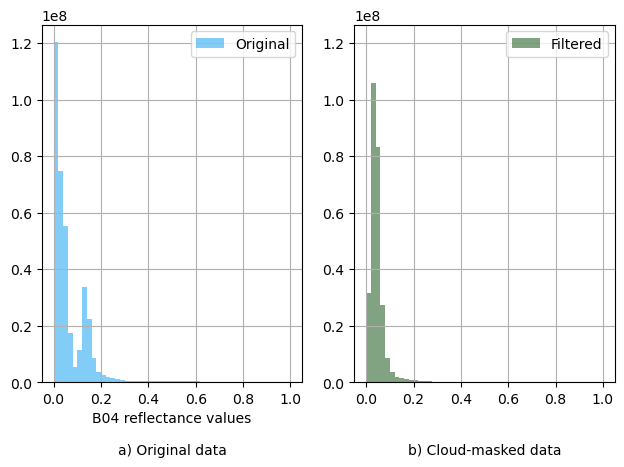

In [ ]:
# visualize cloud-masking in individual bands
fig, axs = plt.subplots(1, 2, tight_layout=True)
axs[0].hist(s2_11_d_data_reduced.sel(band='b03').values.flatten(), bins=50, range=(0,1), alpha=0.5, color ="#069AF3", label="Original") 
axs[1].hist(s2_11_d_data_filtered.sel(band='b03').values.flatten(), bins=50, range=(0,1), alpha=0.5, color ="#054907", label="Filtered") 

axs[0].text(0.5, -0.2, "a) Original data", ha='center', transform=axs[0].transAxes)
axs[1].text(0.5, -0.2, "b) Cloud-masked data", ha='center', transform=axs[1].transAxes)
axs[0].set_xlabel('B04 reflectance values')
axs[0].legend()
axs[1].legend()
axs[0].grid(True)
axs[1].grid(True)
axs[0].set_ylim(0, axs[0].get_ylim()[1])
axs[1].set_ylim(0, axs[0].get_ylim()[1])
plt.tight_layout()
plt.show()
plt.show()

In [23]:
#compute normalized difference indices
def normalized_diff(a, b):
    return (a - b) / (a + b + 1e-6)

b03 = s2_11_d_data_filtered.sel(band='b03')
b04 = s2_11_d_data_filtered.sel(band='b04') #red
b08 = s2_11_d_data_filtered.sel(band='b08') #NIR
b11 = s2_11_d_data_filtered.sel(band='b11') #SWIR
b12 = s2_11_d_data_filtered.sel(band = 'b12')

ndvi = normalized_diff(b08, b04)
ndti = normalized_diff(b11, b12)
ndsi = normalized_diff(b03, b11)
ndmi = normalized_diff(b08, b11)
ndbi = normalized_diff(b11, b08)

indexes = [ndvi, ndti, ndsi, ndmi, ndbi]
index_names = ['ndvi', 'ndti', 'ndsi', 'ndmi', 'ndbi']

In [24]:
for array, name in zip(indexes, index_names):
    array.coords['band'] = name
    array.coords['title'] = name
s2_11_d_index = xr.concat(indexes, dim='band')
s2_11_d_index = s2_11_d_index.transpose('time', 'band', 'y', 'x')
s2_11_d_index.attrs = s2_11_d_data_filtered.attrs

In [ ]:
path_to_training_data = r"stands_Training_data.gpkg"
training_data = gpd.read_file(path_to_training_data)
training_data.head()    
training_data[training_data["SPECIES"] == 1.0].head()



,fid_1,ID,XCOORD,YCOORD,HEIGHT,SPECIES,Shape_Length,Shape_Area,INV_UNIT,PAR_UNIT,...,L_Ch3_LI5_IP2,L_Ch3_LI5_IP3,L_Ch3_LI5_IA1,L_Ch3_LI5_IA2,L_Ch3_LI5_IA3,L_Ch3_D_RF,L_Ch3_D_RL,L_Ch3_D_RI,L_Ch3_D_RO,geometry
85,3267460.0,25923,605207.745,6914930.625,13.020000,1.0,3.0,0.5000,22454085,NaN,...,48314.0,57519.0,48908.500000,34837.000000,48314.000000,0.300000,0.100000,0.200000,0.400000,"MULTIPOLYGON (((605207.37 6914931, 605208.12 6..."
87,3267592.0,25936,605206.370,6914928.500,26.784500,1.0,21.0,14.7500,22454087,NaN,...,44658.0,50560.0,28141.118644,35534.195122,40963.642857,0.246459,0.240793,0.101983,0.410765,"MULTIPOLYGON (((605205.62 6914931, 605206.37 6..."
88,3267631.0,71390,605215.370,6914926.875,26.172701,1.0,17.5,12.5625,22454088,NaN,...,43205.0,53951.0,24637.500000,19468.000000,36023.777778,0.328402,0.310651,0.213018,0.147929,"MULTIPOLYGON (((605215.37 6914928.5, 605216.62..."
89,3267654.0,25949,605199.370,6914927.125,23.370899,1.0,22.0,16.6875,22454089,NaN,...,42500.0,48622.0,20974.533333,26476.333333,35827.964286,0.311804,0.338530,0.175947,0.173719,"MULTIPOLYGON (((605201.12 6914929.5, 605201.37..."
90,3267700.0,27000,605210.370,6914927.250,23.829399,1.0,24.5,17.3125,22454090,NaN,...,49063.0,56462.0,22169.680000,26246.472727,38795.742857,0.304651,0.311628,0.246512,0.137209,"MULTIPOLYGON (((605209.37 6914930, 605209.62 6..."


In [26]:
def calculate_statistics_parallel(vector_df, raster_data):
    stats_list = []

    # Loop through time dimension
    for t in raster_data:
        date_str = np.datetime_as_string(t.time.values, unit="D")
        print("Calculating statistics for", date_str)


        # Loop through bands
        for band in t:
            print("\tCalculating statistics for", str(band.title.values))
            stats_list.append(stats_for_day_band(vector_df, band, date_str))
                
    return stats_list

In [27]:
@dask.delayed
def stats_for_day_band(vector_df, band, date_str):
    band_title = str(band.title.values).upper()
    column_name = f"S2_{date_str}_{band_title}"

    transform = band.transform
    band_data = band.compute().data

    stats = rasterstats.zonal_stats(vector_df.geometry,
                                    band_data,
                                    affine=transform,
                                    stats="mean",
                                    all_touched=True)
    
    stats = pd.Series(
        # Get the calculated mean values out of the dictionaries
        data=[item["mean"] for item in stats],
        index=vector_df.index,
        name=f"{column_name}_MEAN"
    )
    
    return stats 

In [28]:
stats_list = calculate_statistics_parallel(training_data, s2_11_d_data_filtered)
stats = dask.compute(*stats_list)
# Combine all the series into a single df
s2_11_d_stats = pd.concat(stats, axis=1)
s2_11_d_stats

Calculating statistics for 2019-04-11
	Calculating statistics for b02
	Calculating statistics for b03
	Calculating statistics for b04
	Calculating statistics for b05
	Calculating statistics for b06
	Calculating statistics for b07
	Calculating statistics for b08
	Calculating statistics for b8a
	Calculating statistics for b11
	Calculating statistics for b12
Calculating statistics for 2019-04-21
	Calculating statistics for b02
	Calculating statistics for b03
	Calculating statistics for b04
	Calculating statistics for b05
	Calculating statistics for b06
	Calculating statistics for b07
	Calculating statistics for b08
	Calculating statistics for b8a
	Calculating statistics for b11
	Calculating statistics for b12
Calculating statistics for 2019-05-01
	Calculating statistics for b02
	Calculating statistics for b03
	Calculating statistics for b04
	Calculating statistics for b05
	Calculating statistics for b06
	Calculating statistics for b07
	Calculating statistics for b08
	Calculating statistic

/PUHTI_TYKKY_IhY5c16/miniconda/envs/env1/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 40.08 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/PUHTI_TYKKY_IhY5c16/miniconda/envs/env1/lib/python3.11/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(
/PUHTI_TYKKY_IhY5c16/miniconda/envs/env1/lib/python3.11/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


,S2_2019-04-11_B02_MEAN,S2_2019-04-11_B03_MEAN,S2_2019-04-11_B04_MEAN,S2_2019-04-11_B05_MEAN,S2_2019-04-11_B06_MEAN,S2_2019-04-11_B07_MEAN,S2_2019-04-11_B08_MEAN,S2_2019-04-11_B8A_MEAN,S2_2019-04-11_B11_MEAN,S2_2019-04-11_B12_MEAN,...,S2_2022-05-11_B02_MEAN,S2_2022-05-11_B03_MEAN,S2_2022-05-11_B04_MEAN,S2_2022-05-11_B05_MEAN,S2_2022-05-11_B06_MEAN,S2_2022-05-11_B07_MEAN,S2_2022-05-11_B08_MEAN,S2_2022-05-11_B8A_MEAN,S2_2022-05-11_B11_MEAN,S2_2022-05-11_B12_MEAN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.011800,0.0230,0.019600,0.046300,0.103800,0.123800,0.129000,0.141000,0.070600,0.03930
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.011800,0.0230,0.019600,0.046300,0.103800,0.123800,0.129000,0.141000,0.070600,0.03930
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.010850,0.0228,0.018050,0.045050,0.102500,0.122300,0.133200,0.136100,0.069050,0.03725
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.011800,0.0230,0.019600,0.046300,0.103800,0.123800,0.129000,0.141000,0.070600,0.03930
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.011333,0.0234,0.019067,0.045633,0.106033,0.125367,0.137233,0.142733,0.068967,0.03770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.020600,0.0332,0.038300,0.062200,0.100000,0.113200,0.129000,0.129900,0.134400,0.08120
3915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.025900,0.0443,0.047600,0.081400,0.137000,0.153000,0.168300,0.172900,0.167000,0.10540
3916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.020600,0.0332,0.038300,0.062200,0.100000,0.113200,0.129000,0.129900,0.134400,0.08120
3917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.018600,0.0370,0.038000,0.072000,0.118600,0.136000,0.149400,0.147300,0.149800,0.09250


In [29]:
index_stats_list = calculate_statistics_parallel(training_data, s2_11_d_index)
stats = dask.compute(*index_stats_list)
# Combine all the series into a single df
s2_11_d_index_stats = pd.concat(stats, axis=1)
s2_11_d_index_stats

Calculating statistics for 2019-04-11
	Calculating statistics for ndvi
	Calculating statistics for ndti
	Calculating statistics for ndsi
	Calculating statistics for ndmi
	Calculating statistics for ndbi
Calculating statistics for 2019-04-21
	Calculating statistics for ndvi
	Calculating statistics for ndti
	Calculating statistics for ndsi
	Calculating statistics for ndmi
	Calculating statistics for ndbi
Calculating statistics for 2019-05-01
	Calculating statistics for ndvi
	Calculating statistics for ndti
	Calculating statistics for ndsi
	Calculating statistics for ndmi
	Calculating statistics for ndbi
Calculating statistics for 2019-05-11
	Calculating statistics for ndvi
	Calculating statistics for ndti
	Calculating statistics for ndsi
	Calculating statistics for ndmi
	Calculating statistics for ndbi
Calculating statistics for 2019-05-21
	Calculating statistics for ndvi
	Calculating statistics for ndti
	Calculating statistics for ndsi
	Calculating statistics for ndmi
	Calculating stati

/PUHTI_TYKKY_IhY5c16/miniconda/envs/env1/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 28.45 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


,S2_2019-04-11_NDVI_MEAN,S2_2019-04-11_NDTI_MEAN,S2_2019-04-11_NDSI_MEAN,S2_2019-04-11_NDMI_MEAN,S2_2019-04-11_NDBI_MEAN,S2_2019-04-21_NDVI_MEAN,S2_2019-04-21_NDTI_MEAN,S2_2019-04-21_NDSI_MEAN,S2_2019-04-21_NDMI_MEAN,S2_2019-04-21_NDBI_MEAN,...,S2_2022-05-01_NDVI_MEAN,S2_2022-05-01_NDTI_MEAN,S2_2022-05-01_NDSI_MEAN,S2_2022-05-01_NDMI_MEAN,S2_2022-05-01_NDBI_MEAN,S2_2022-05-11_NDVI_MEAN,S2_2022-05-11_NDTI_MEAN,S2_2022-05-11_NDSI_MEAN,S2_2022-05-11_NDMI_MEAN,S2_2022-05-11_NDBI_MEAN
0,NaN,NaN,NaN,NaN,NaN,0.633689,0.248247,-0.290424,0.350606,-0.350606,...,0.555552,0.104788,-0.389176,0.203999,-0.203999,0.736200,0.284802,-0.508542,0.292584,-0.292584
1,NaN,NaN,NaN,NaN,NaN,0.633689,0.248247,-0.290424,0.350606,-0.350606,...,0.555552,0.104788,-0.389176,0.203999,-0.203999,0.736200,0.284802,-0.508542,0.292584,-0.292584
2,NaN,NaN,NaN,NaN,NaN,0.661455,0.285633,-0.294318,0.373892,-0.373892,...,0.631354,0.204990,-0.353963,0.308924,-0.308924,0.760885,0.299654,-0.503436,0.316862,-0.316862
3,NaN,NaN,NaN,NaN,NaN,0.633689,0.248247,-0.290424,0.350606,-0.350606,...,0.555552,0.104788,-0.389176,0.203999,-0.203999,0.736200,0.284802,-0.508542,0.292584,-0.292584
4,NaN,NaN,NaN,NaN,NaN,0.644861,0.262896,-0.288295,0.356575,-0.356575,...,0.546718,0.107079,-0.428077,0.190985,-0.190985,0.754242,0.293659,-0.492901,0.328753,-0.328753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3914,NaN,NaN,NaN,NaN,NaN,0.605506,0.291336,-0.313048,0.279753,-0.279753,...,0.535692,0.227878,-0.562261,0.062995,-0.062995,0.542137,0.246752,-0.603815,-0.020501,0.020501
3915,NaN,NaN,NaN,NaN,NaN,0.567032,0.202306,-0.354321,0.189108,-0.189108,...,0.576366,0.240672,-0.623741,-0.016482,0.016482,0.559053,0.226137,-0.580688,0.003877,-0.003877
3916,NaN,NaN,NaN,NaN,NaN,0.605506,0.291336,-0.313048,0.279753,-0.279753,...,0.535692,0.227878,-0.562261,0.062995,-0.062995,0.542137,0.246752,-0.603815,-0.020501,0.020501
3917,NaN,NaN,NaN,NaN,NaN,0.592015,0.159175,-0.374027,0.183646,-0.183646,...,0.652170,0.253225,-0.646780,0.038251,-0.038251,0.594447,0.236483,-0.603851,-0.001337,0.001337


In [30]:
preprocessed_stats = pd.concat([s2_11_d_index_stats, s2_11_d_stats, training_data], axis=1)

In [32]:
training_data_modified = gpd.GeoDataFrame(preprocessed_stats, geometry='geometry', crs="EPSG:3067")
td_out_path = r"training_data_preprocessed.gpkg"
td_layer_name = "stands_Training_data"
training_data_modified.to_file(td_out_path, layer=td_layer_name, driver="GPKG")

In [34]:
# cdf per polygon per year to extract 25%, 50%, and 75% accumulation.
cdfs = []
thresholds = [0.25, 0.5, 0.75]
labels     = ['cdf25', 'cdf50', 'cdf75']

def calculate_temporal_features(band, grouped_dates):
    print(grouped_dates)
    dates_mean = grouped_dates.mean()
    cumulative_dist =  dates_mean.cumsum(axis=1).div(dates_mean.sum(axis=1), axis=0)
    band_features = pd.DataFrame(index=cumulative_dist.index)
    # find first day of year crossing each threshold
    for thr, label in zip(thresholds, labels):
        date_at_thr = cumulative_dist.apply(lambda row: row.index[row >= thr][0], axis=1)
        day = pd.to_datetime("2019-" + date_at_thr, format="%Y-%m-%d").dt.dayofyear
        band_features[f'{band.upper()}_day_of_{label}'] = day
    # calculate duration between 25% and 75% accumulation in days
    duration = ((band_features[f'{band.upper()}_day_of_cdf75'] - band_features[f'{band.upper()}_day_of_cdf25'] )).astype('Int64')
    band_features[f'{band.upper()}_duration_25_to_75'] = duration
    band_features[f'{band.upper()}_day_of_max_reflectance'] = pd.to_datetime("2019-" + dates_mean.idxmax(axis=1), format="%Y-%m-%d").dt.dayofyear
    band_features[f'{band.upper()}_day_of_min_reflectance'] = pd.to_datetime("2019-" + dates_mean.idxmin(axis=1), format="%Y-%m-%d").dt.dayofyear
    band_features[f'{band.upper()}_slope_25_to_75'] =  0.5*dates_mean.sum(axis=1)
    return band_features

for band in s2_11_d_data_reduced.band.to_numpy():
    band_cols = [col for col in s2_11_d_stats.columns if band in str(col).lower()]
    dates = pd.to_datetime([col.split('_')[1] for col in band_cols]).strftime("%m-%d")
    grouped_dates = s2_11_d_stats[band_cols].groupby(dates, axis=1)
    band_features = calculate_temporal_features(band, grouped_dates)
    cdfs.append(band_features)
mosaic_features_cdf = pd.concat(cdfs, axis=1)

/run/nvme/job_29113953/tmp/ipykernel_328676/3773845893.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped_dates = s2_11_d_stats[band_cols].groupby(dates, axis=1)


/run/nvme/job_29113953/tmp/ipykernel_328676/3773845893.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped_dates = s2_11_d_stats[band_cols].groupby(dates, axis=1)


/run/nvme/job_29113953/tmp/ipykernel_328676/3773845893.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped_dates = s2_11_d_stats[band_cols].groupby(dates, axis=1)


/run/nvme/job_29113953/tmp/ipykernel_328676/3773845893.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped_dates = s2_11_d_stats[band_cols].groupby(dates, axis=1)


/run/nvme/job_29113953/tmp/ipykernel_328676/3773845893.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped_dates = s2_11_d_stats[band_cols].groupby(dates, axis=1)


/run/nvme/job_29113953/tmp/ipykernel_328676/3773845893.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped_dates = s2_11_d_stats[band_cols].groupby(dates, axis=1)


/run/nvme/job_29113953/tmp/ipykernel_328676/3773845893.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped_dates = s2_11_d_stats[band_cols].groupby(dates, axis=1)


/run/nvme/job_29113953/tmp/ipykernel_328676/3773845893.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped_dates = s2_11_d_stats[band_cols].groupby(dates, axis=1)


/run/nvme/job_29113953/tmp/ipykernel_328676/3773845893.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped_dates = s2_11_d_stats[band_cols].groupby(dates, axis=1)


/run/nvme/job_29113953/tmp/ipykernel_328676/3773845893.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped_dates = s2_11_d_stats[band_cols].groupby(dates, axis=1)


In [35]:
mosaic_features_cdf

,B02_day_of_cdf25,B02_day_of_cdf50,B02_day_of_cdf75,B02_duration_25_to_75,B02_day_of_max_reflectance,B02_day_of_min_reflectance,B02_slope_25_to_75,B03_day_of_cdf25,B03_day_of_cdf50,B03_day_of_cdf75,...,B11_day_of_max_reflectance,B11_day_of_min_reflectance,B11_slope_25_to_75,B12_day_of_cdf25,B12_day_of_cdf50,B12_day_of_cdf75,B12_duration_25_to_75,B12_day_of_max_reflectance,B12_day_of_min_reflectance,B12_slope_25_to_75
0,121,182,244,123,91,244,0.264600,141,192,254,...,182,264,0.772608,131,182,233,102,91,264,0.397646
1,121,182,244,123,91,244,0.264600,141,192,254,...,182,264,0.772608,131,182,233,102,91,264,0.397646
2,121,182,244,123,101,244,0.239877,141,192,244,...,182,264,0.714206,131,182,233,102,182,264,0.356679
3,121,182,244,123,91,244,0.264600,141,192,254,...,182,264,0.772608,131,182,233,102,91,264,0.397646
4,111,182,244,133,91,244,0.251472,131,192,244,...,182,264,0.730988,131,182,233,102,91,264,0.374005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3914,172,223,284,112,294,264,0.339656,152,213,284,...,182,284,0.920196,131,182,244,113,131,264,0.503015
3915,141,223,284,143,294,264,0.431243,141,202,274,...,182,284,1.192336,131,182,244,113,244,264,0.667351
3916,172,223,284,112,294,264,0.339656,152,213,284,...,182,284,0.920196,131,182,244,113,131,264,0.503015
3917,152,233,284,132,294,264,0.389502,141,213,274,...,182,284,1.064805,131,182,244,113,244,264,0.591380


In [37]:
indexes = ["NDVI", "NDTI", "NDSI", "NDMI", "NDBI"]
monthly_means_index = []

for index in indexes:
    index_cols = training_data.filter(like = index)
    index_year_month = index + "_" + index_cols.columns.str.extract(r'S2_(\d{4}-\d{2})', expand=False)
    monthly = index_cols.groupby(index_year_month, axis=1).mean()
    monthly_means_index.append(monthly)
s2_index_monthly = pd.concat(monthly_means_index, axis=1)

/run/nvme/job_29113953/tmp/ipykernel_328676/2650944987.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  monthly = index_cols.groupby(index_year_month, axis=1).mean()
/run/nvme/job_29113953/tmp/ipykernel_328676/2650944987.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  monthly = index_cols.groupby(index_year_month, axis=1).mean()
/run/nvme/job_29113953/tmp/ipykernel_328676/2650944987.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  monthly = index_cols.groupby(index_year_month, axis=1).mean()
/run/nvme/job_29113953/tmp/ipykernel_328676/2650944987.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  monthly = index_cols.groupby(index_year_month, axis=1).mean()
/run/nvme/job_29113953/tmp/ipykernel_328676/2650944987.py:7: FutureW

In [ ]:
indexes = ["NDVI", "NDTI", "NDSI", "NDMI", "NDBI"]
month_day_mean_index = []
for index in indexes:
    index_cols = s2_index_monthly.filter(like = index)
    index_month_day = index + "_" + index_cols.columns.str.extract(r'_\d{4}-(\d{2}-\d{2})', expand=False) +"_MEAN"
    month_day = index_cols.groupby(index_month_day, axis=1).mean()
    month_day_mean_index.append(month_day)
s2_index_month_day = pd.concat(month_day_mean_index, axis=1)

In [44]:
data = pd.concat([training_data, mosaic_features_cdf, s2_index_monthly], axis=1)

In [61]:
bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8a', 'B11', 'B12']
monthly_means_mosaic = []
for band in bands:
    cols = s2_11_d_stats.filter(like=f"_{band}_MEAN")
    band_year_month_day = band + "_" + cols.columns.str.extract(r"S2_(\d{4}-\d{2}-\d{2})", expand=False)
    monthly = cols.groupby(band_year_month_day, axis=1).mean()
    monthly_means_mosaic.append(monthly)
s2_mosaic_monthly = pd.concat(monthly_means_mosaic, axis=1)


/run/nvme/job_29113953/tmp/ipykernel_328676/2685395990.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  monthly = cols.groupby(band_year_month_day, axis=1).mean()
/run/nvme/job_29113953/tmp/ipykernel_328676/2685395990.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  monthly = cols.groupby(band_year_month_day, axis=1).mean()
/run/nvme/job_29113953/tmp/ipykernel_328676/2685395990.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  monthly = cols.groupby(band_year_month_day, axis=1).mean()
/run/nvme/job_29113953/tmp/ipykernel_328676/2685395990.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  monthly = cols.groupby(band_year_month_day, axis=1).mean()
/run/nvme/job_29113953/tmp/ipykernel_328676/2685395990.py:6: FutureWarning: Data

In [62]:
bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8a', 'B11', 'B12']
yearly_means_mosaic = []
for band in bands:
    cols = s2_mosaic_monthly.filter(like=f"{band}_")
    band_month_day = band + "_" + cols.columns.str.extract(r".-(\d{2}-\d{2})", expand=False) + "_MEAN"
    month_day = cols.groupby(band_month_day, axis=1).mean()
    yearly_means_mosaic.append(month_day)
s2_mosaic_over_years = pd.concat(yearly_means_mosaic, axis=1)

/run/nvme/job_29113953/tmp/ipykernel_328676/467276544.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  month_day = cols.groupby(band_month_day, axis=1).mean()
/run/nvme/job_29113953/tmp/ipykernel_328676/467276544.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  month_day = cols.groupby(band_month_day, axis=1).mean()
/run/nvme/job_29113953/tmp/ipykernel_328676/467276544.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  month_day = cols.groupby(band_month_day, axis=1).mean()
/run/nvme/job_29113953/tmp/ipykernel_328676/467276544.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  month_day = cols.groupby(band_month_day, axis=1).mean()
/run/nvme/job_29113953/tmp/ipykernel_328676/467276544.py:6: FutureWarning: DataFrame.groupby wit

In [46]:
preprocessed_stats["polygon_id"] = preprocessed_stats.index

In [47]:
data.query("SPECIES == 3.0").filter(like="max").mean()


B02_day_of_max_reflectance    192.630923
B03_day_of_max_reflectance    191.703242
B04_day_of_max_reflectance    186.915212
B05_day_of_max_reflectance    179.316708
B06_day_of_max_reflectance    188.354115
B07_day_of_max_reflectance    190.763092
B08_day_of_max_reflectance    192.274314
B8A_day_of_max_reflectance    195.548628
B11_day_of_max_reflectance    171.299252
B12_day_of_max_reflectance    165.763092
dtype: float64

In [48]:
data.query("SPECIES == 2.0").filter(like="max").mean()

B02_day_of_max_reflectance    193.281843
B03_day_of_max_reflectance    190.396438
B04_day_of_max_reflectance    188.353852
B05_day_of_max_reflectance    178.431281
B06_day_of_max_reflectance    190.663957
B07_day_of_max_reflectance    196.058459
B08_day_of_max_reflectance    194.274100
B8A_day_of_max_reflectance    196.121177
B11_day_of_max_reflectance    179.639954
B12_day_of_max_reflectance    173.429346
dtype: float64

In [49]:
data.query("SPECIES == 1.0").filter(like="max").mean()

B02_day_of_max_reflectance    159.113369
B03_day_of_max_reflectance    154.912299
B04_day_of_max_reflectance    152.735829
B05_day_of_max_reflectance    146.884492
B06_day_of_max_reflectance    160.488770
B07_day_of_max_reflectance    168.417112
B08_day_of_max_reflectance    164.449198
B8A_day_of_max_reflectance    171.125134
B11_day_of_max_reflectance    170.383957
B12_day_of_max_reflectance    163.911230
dtype: float64

In [51]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(data.describe())

,fid_1,ID,XCOORD,YCOORD,HEIGHT,SPECIES,Shape_Length,Shape_Area,INV_UNIT,PAR_UNIT,L_Ch1_VEG_Z95,L_Ch1_VEG_Z90,L_Ch1_VEG_Z85,L_Ch1_VEG_Z80,L_Ch1_VEG13_Z95,L_Ch1_VEG13_Z90,L_Ch1_VEG13_Z85,L_Ch1_VEG13_Z80,L_Ch1_X_VD,L_Ch1_X_ZP85,L_Ch1_X_ZP95,L_Ch1_L30M_01,L_Ch1_L30M_02,L_Ch1_L30M_03,L_Ch1_L30M_04,L_Ch1_L30M_05,L_Ch1_L30M_06,L_Ch1_L30M_07,L_Ch1_L30M_08,L_Ch1_L30M_09,L_Ch1_L30M_10,L_Ch1_L30M_11,L_Ch1_L30M_12,L_Ch1_L30M_13,L_Ch1_L30M_14,L_Ch1_L30M_15,L_Ch1_L30M_16,L_Ch1_L30M_17,L_Ch1_L30M_18,L_Ch1_L30M_19,L_Ch1_L30M_20,L_Ch1_L30M_21,L_Ch1_L30M_22,L_Ch1_L30M_23,L_Ch1_L30M_24,L_Ch1_L30M_25,L_Ch1_L30M_26,L_Ch1_L30M_27,L_Ch1_L30M_28,L_Ch1_L30M_29,L_Ch1_L30M_30,L_Ch1_L27M_11,L_Ch1_L27M_12,L_Ch1_L27M_13,L_Ch1_L27M_14,L_Ch1_L27M_15,L_Ch1_L27M_16,L_Ch1_L27M_17,L_Ch1_L27M_18,L_Ch1_L27M_19,L_Ch1_L27M_20,L_Ch1_L27M_21,L_Ch1_L27M_22,L_Ch1_L27M_23,L_Ch1_L27M_24,L_Ch1_L27M_26,L_Ch1_L27M_27,L_Ch1_L30Y_27,L_Ch1_L30Y_29,L_Ch1_L30Y_30,L_Ch1_L27Y_26,L_Ch1_L30M5_29,L_Ch1_L30M5_30,L_Ch1_L30M7_29,L_Ch1_L30M7_30,L_Ch1_VD8530VD,L_Ch1_VD8580VD,L_Ch1_VD9030VD,L_Ch1_VD9080VD,L_Ch1_VD9530VD,L_Ch1_VD9580VD,L_Ch1_VD9550VD,L_Ch1_VD05MVD,L_Ch1_VD3MVD,L_Ch1_VD053MVD,L_Ch1_FI2_IP1,L_Ch1_FI2_IP2,L_Ch1_FI2_IP3,L_Ch1_FI2_IA1,L_Ch1_FI2_IA2,L_Ch1_FI2_IA3,L_Ch1_LI2_IP1,L_Ch1_LI2_IP2,L_Ch1_LI2_IP3,L_Ch1_LI2_IA1,L_Ch1_LI2_IA2,L_Ch1_LI2_IA3,L_Ch1_FI5_IP1,L_Ch1_FI5_IP2,L_Ch1_FI5_IP3,L_Ch1_FI5_IA1,L_Ch1_FI5_IA2,L_Ch1_FI5_IA3,L_Ch1_LI5_IP1,L_Ch1_LI5_IP2,L_Ch1_LI5_IP3,L_Ch1_LI5_IA1,L_Ch1_LI5_IA2,L_Ch1_LI5_IA3,L_Ch1_D_RF,L_Ch1_D_RL,L_Ch1_D_RI,L_Ch1_D_RO,L__EC,L_Ch2_VEG_Z95,L_Ch2_VEG_Z90,L_Ch2_VEG_Z85,L_Ch2_VEG_Z80,L_Ch2_VEG13_Z95,L_Ch2_VEG13_Z90,L_Ch2_VEG13_Z85,L_Ch2_VEG13_Z80,L_Ch2_X_VD,L_Ch2_X_ZP85,L_Ch2_X_ZP95,L_Ch2_L30M_01,L_Ch2_L30M_02,L_Ch2_L30M_03,L_Ch2_L30M_04,L_Ch2_L30M_05,L_Ch2_L30M_06,L_Ch2_L30M_07,L_Ch2_L30M_08,L_Ch2_L30M_09,L_Ch2_L30M_10,L_Ch2_L30M_11,L_Ch2_L30M_12,L_Ch2_L30M_13,L_Ch2_L30M_14,L_Ch2_L30M_15,L_Ch2_L30M_16,L_Ch2_L30M_17,L_Ch2_L30M_18,L_Ch2_L30M_19,L_Ch2_L30M_20,L_Ch2_L30M_21,L_Ch2_L30M_22,L_Ch2_L30M_23,L_Ch2_L30M_24,L_Ch2_L30M_25,L_Ch2_L30M_26,L_Ch2_L30M_27,L_Ch2_L30M_28,L_Ch2_L30M_29,L_Ch2_L30M_30,L_Ch2_L27M_11,L_Ch2_L27M_12,L_Ch2_L27M_13,L_Ch2_L27M_14,L_Ch2_L27M_15,L_Ch2_L27M_16,L_Ch2_L27M_17,L_Ch2_L27M_18,L_Ch2_L27M_19,L_Ch2_L27M_20,L_Ch2_L27M_21,L_Ch2_L27M_22,L_Ch2_L27M_23,L_Ch2_L27M_24,L_Ch2_L27M_26,L_Ch2_L27M_27,L_Ch2_L30Y_27,L_Ch2_L30Y_29,L_Ch2_L30Y_30,L_Ch2_L27Y_26,L_Ch2_L30M5_29,L_Ch2_L30M5_30,L_Ch2_L30M7_29,L_Ch2_L30M7_30,L_Ch2_VD8530VD,L_Ch2_VD8580VD,L_Ch2_VD9030VD,L_Ch2_VD9080VD,L_Ch2_VD9530VD,L_Ch2_VD9580VD,L_Ch2_VD9550VD,L_Ch2_VD05MVD,L_Ch2_VD3MVD,L_Ch2_VD053MVD,L_Ch2_FI2_IP1,L_Ch2_FI2_IP2,L_Ch2_FI2_IP3,L_Ch2_FI2_IA1,L_Ch2_FI2_IA2,L_Ch2_FI2_IA3,L_Ch2_LI2_IP1,L_Ch2_LI2_IP2,L_Ch2_LI2_IP3,L_Ch2_LI2_IA1,L_Ch2_LI2_IA2,L_Ch2_LI2_IA3,L_Ch2_FI5_IP1,L_Ch2_FI5_IP2,L_Ch2_FI5_IP3,L_Ch2_FI5_IA1,L_Ch2_FI5_IA2,L_Ch2_FI5_IA3,L_Ch2_LI5_IP1,L_Ch2_LI5_IP2,L_Ch2_LI5_IP3,L_Ch2_LI5_IA1,L_Ch2_LI5_IA2,L_Ch2_LI5_IA3,L_Ch2_D_RF,L_Ch2_D_RL,L_Ch2_D_RI,L_Ch2_D_RO,L_Ch3_VEG_Z95,L_Ch3_VEG_Z90,L_Ch3_VEG_Z85,L_Ch3_VEG_Z80,L_Ch3_VEG13_Z95,L_Ch3_VEG13_Z90,L_Ch3_VEG13_Z85,L_Ch3_VEG13_Z80,L_Ch3_X_VD,L_Ch3_X_ZP85,L_Ch3_X_ZP95,L_Ch3_L30M_01,L_Ch3_L30M_02,L_Ch3_L30M_03,L_Ch3_L30M_04,L_Ch3_L30M_05,L_Ch3_L30M_06,L_Ch3_L30M_07,L_Ch3_L30M_08,L_Ch3_L30M_09,L_Ch3_L30M_10,L_Ch3_L30M_11,L_Ch3_L30M_12,L_Ch3_L30M_13,L_Ch3_L30M_14,L_Ch3_L30M_15,L_Ch3_L30M_16,L_Ch3_L30M_17,L_Ch3_L30M_18,L_Ch3_L30M_19,L_Ch3_L30M_20,L_Ch3_L30M_21,L_Ch3_L30M_22,L_Ch3_L30M_23,L_Ch3_L30M_24,L_Ch3_L30M_25,L_Ch3_L30M_26,L_Ch3_L30M_27,L_Ch3_L30M_28,L_Ch3_L30M_29,L_Ch3_L30M_30,L_Ch3_L27M_11,L_Ch3_L27M_12,L_Ch3_L27M_13,L_Ch3_L27M_14,L_Ch3_L27M_15,L_Ch3_L27M_16,L_Ch3_L27M_17,L_Ch3_L27M_18,L_Ch3_L27M_19,L_Ch3_L27M_20,L_Ch3_L27M_21,L_Ch3_L27M_22,L_Ch3_L27M_23,L_Ch3_L27M_24,L_Ch3_L27M_26,L_Ch3_L27M_27,L_Ch3_L30Y_27,L_Ch3_L30Y_29,L_Ch3_L30Y_30,L_Ch3_L27Y_26,L_Ch3_L30M5_29,L_Ch3_L30M5_30,L_Ch3_L30M7_29,L_Ch3_L30M7_30,L_Ch3_VD8530VD,L_Ch3_VD8580VD,L_Ch3_VD9030VD,L_Ch3_VD9080VD,L_Ch3_VD9530VD,L_Ch3_VD9580VD,L_Ch3_VD9550VD,L_C

In [ ]:
training_data_modified = gpd.GeoDataFrame(data, geometry='geometry', crs="EPSG:3067")
td_out_path = r"training_data_wide_over_years.gpkg"
td_layer_name = "stands_Training_data"
training_data_modified.to_file(td_out_path, layer=td_layer_name, driver="GPKG")

In [65]:
training_data_dates_over_years = pd.concat([training_data, s2_mosaic_over_years, s2_index_month_day], axis=1)
training_data_new = gpd.GeoDataFrame(training_data_dates_over_years, geometry='geometry', crs="EPSG:3067")
td_out_path = r"training_data_dates_over_years.gpkg"
td_layer_name = "stands_Training_data"
training_data_new.to_file(td_out_path, layer=td_layer_name, driver="GPKG")

In [ ]:
end_time = time.time()
end_mem = process.memory_info().rss / (1024 ** 2) 

print(f"Total execution time: {end_time - start_time:.2f} seconds")
print(f"Start memory usage: {start_mem:.2f} MB")
print(f"End memory usage: {end_mem:.2f} MB")
print(f"Peak memory usage: {resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024:.2f} MB")

Total execution time: 17683.08 seconds
Start memory usage: 336.51 MB
End memory usage: 8859.52 MB
Peak memory usage: 11660.61 MB
